# Machin Learning Computer Assignment
## AI CA4
## Rezvan Bahmani 810197473

In [80]:
from hazm import *
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import copy
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_squared_error as MSE

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

mse_for_grid = 'neg_root_mean_squared_error'

space = ' '

trainAddress = "vehicles.csv"
swAddress = "sw.csv"

title = "title"
desc = "description"
cat = "categories"

target = 'price'

brand = 'brand'
category = 'category'
date = 'created_at'
description = 'description'
image_count = 'image_count'
mileage = 'mileage'
price = 'price'
title = 'title'
year = 'year'

heavy = 'heavy'
light = 'light'

day = 'day'
hour = 'hour'
weekDays = [ 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

heavyVal = 1
lightVal = 1

smooth = True

digitNum = 4

MinwrongPriceInserted = 999

tozih = 'tozih'

In [81]:
def loadData(address):
    df = pd.read_csv(address)
    return df
train = loadData(trainAddress)

In [82]:
train_copy = train.copy()
train_copy.drop(description, axis = 1, inplace = True)
train_copy.drop(brand, axis = 1, inplace = True)
train_copy.drop(title, axis = 1, inplace = True)
print(train_copy.head().to_markdown())

|    | category   | created_at     |   image_count |   mileage |    price |   year |
|---:|:-----------|:---------------|--------------:|----------:|---------:|-------:|
|  0 | heavy      | Tuesday 07PM   |             4 |       nan |       -1 |    nan |
|  1 | light      | Wednesday 04AM |             3 |    180000 |       -1 |   1366 |
|  2 | light      | Wednesday 11AM |             0 |    290000 |  8500000 |   1381 |
|  3 | light      | Wednesday 01PM |             3 |    175000 | 19500000 |   1372 |
|  4 | light      | Thursday 07AM  |             4 |     80000 | 23900000 |   1391 |


In [83]:
train = train[train[target] > MinwrongPriceInserted]

In [84]:
train = train[train[brand].notna()]

In [85]:
def FixCategory(df):
    df[category] = df[category].replace([heavy], heavyVal)
    df[category] = df[category].replace([light], lightVal)
    
FixCategory(train)

In [86]:
def handleDate(data, columnName, newColumns):
    dates = data[columnName].astype(str)
    day = list()
    time = list()
    for date in dates:
        splitedDate = date.split(maxsplit=2)
        day.append(splitedDate[0])
        timeAMPM = splitedDate[1][2:]
        timeValue = int(splitedDate[1][:2])
        timeValue += 12 if timeAMPM == 'PM' else 0
        time.append(timeValue)
    data.drop(columns=[columnName], inplace=True)
    data[newColumns[0]] = day
    data[newColumns[1]] = time
    
handleDate(train, columnName=date , newColumns=['day', 'hour'])

In [87]:
def FixDays(df):
    for today, todayVal in zip(weekDays, range(7)):
        df[day] = df[day].replace([today], todayVal)
    
FixDays(train)

In [88]:
cols_to_check = [year]
train[cols_to_check] = train[cols_to_check].replace({'<':''}, regex=True)

StrYearList = train[year].tolist()
IntYearList = []
for x in StrYearList:
    IntYearList.append(int(x))
    
train.drop(year, axis = 1, inplace = True)
train[year] = IntYearList

In [89]:
def fixBrand(df):
    dummy = pd.get_dummies(df[brand])
    df = pd.concat([df, dummy], axis = 1)
    del df[brand]
    return df

train = fixBrand(train)

In [90]:
def RemovePunct(df, col):
    newCol = []
    for ind in df.index:
        newCol_ele = re.sub(r'\W', ' ', df[col][ind])
        newCol.append(newCol_ele)
    df.drop(col, axis = 1, inplace = True)
    df[col] = newCol

RemovePunct(train, title)
RemovePunct(train, description)
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,title,description
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,1,0,0,پژو مدل 81 مشکی,پژو 2000فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,پاترول 2در,سلام ماشین کاملا سالم همه چی فابریک متور زد ژ...
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,سمند دوگانه کارخانه,سمند ال ایکس بدون رنگ تمامی سرویس ها انجام شده...
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,1,0,0,پژو405 مدل84,بیمه یکسال ده سال تخفیف دور رنگ شاسی پلمپ سالم
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,ام وی ام 110 چهار سیلندر,ام وی ام چهار سیلندر مدل 93 فنی سالم بدون رنگ ...


In [91]:
def Normal(df, col):
    normalizer = Normalizer()
    newCol = []
    for ind in df.index:
        case = df[col][ind]
        newCol_ele = normalizer.normalize(case)
        newCol.append(newCol_ele)
    df.drop(col, axis = 1, inplace = True)
    df[col] = newCol

Normal(train, title)
Normal(train, description)
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,title,description
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,1,0,0,پژو مدل ۸۱ مشکی,پژو ۲۰۰۰فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,پاترول ۲در,سلام ماشین کاملا سالم همه چی فابریک متور زد ژا...
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,سمند دوگانه کارخانه,سمند ال ایکس بدون رنگ تمامی سرویس‌ها انجام شده...
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,1,0,0,پژو۴۰۵ مدل۸۴,بیمه یکسال ده سال تخفیف دور رنگ شاسی پلمپ سالم
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,ام وی ام ۱۱۰ چهار سیلندر,ام وی ام چهار سیلندر مدل ۹۳ فنی سالم بدون رنگ ...


In [92]:
def wordTokenize(df, col):
    newCol = []
    for ind in df.index:
        newCol_ele = word_tokenize(df[col][ind])
        newCol.append(newCol_ele)
    df.drop(col, axis = 1, inplace = True)
    df[col] = newCol

wordTokenize(train, title)
wordTokenize(train, description)
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,title,description
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,1,0,0,"[پژو, مدل, ۸۱, مشکی]","[پژو, ۲۰۰۰, فنی, تازه, تعمیر, بدنه, بدون, خطو,..."
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,"[پاترول, ۲در]","[سلام, ماشین, کاملا, سالم, همه, چی, فابریک, مت..."
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,"[سمند, دوگانه, کارخانه]","[سمند, ال, ایکس, بدون, رنگ, تمامی, سرویس‌ها, ا..."
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,1,0,0,"[پژو, ۴۰۵, مدل, ۸۴]","[بیمه, یکسال, ده, سال, تخفیف, دور, رنگ, شاسی, ..."
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,"[ام, وی, ام, ۱۱۰, چهار, سیلندر]","[ام, وی, ام, چهار, سیلندر, مدل, ۹۳, فنی, سالم,..."


In [93]:
def loadSW():
    sw = pd.read_csv(swAddress)
    sw = sw['word'].tolist()
    return sw

def removeSW(df, col, sw):
    newCol = []
    for ind in df.index:
        case = df[col][ind]
        filtered = []
        for word in case:
            if word not in sw:
                filtered.append(word)
        newCol.append(filtered)
    df.drop(col, axis = 1, inplace = True)
    df[col] = newCol
    
    
sw = loadSW()
removeSW(train, title, sw)
removeSW(train, desc, sw)
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,title,description
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,1,0,0,"[پژو, مدل, ۸۱, مشکی]","[پژو, ۲۰۰۰, فنی, تعمیر, بدنه, خطو, خش, تخیف, ب..."
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,"[پاترول, ۲در]","[سلام, ماشین, چی, فابریک, متور, ژاپن, لاستیکها..."
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,"[سمند, دوگانه, کارخانه]","[سمند, ال, ایکس, رنگ, تمامی, سرویس‌ها, لاستیک,..."
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,1,0,0,"[پژو, ۴۰۵, مدل, ۸۴]","[بیمه, یکسال, سال, تخفیف, رنگ, شاسی, پلمپ]"
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,"[۱۱۰, سیلندر]","[سیلندر, مدل, ۹۳, فنی, رنگ, تخفیف, بیمه]"


In [94]:
def RisheYabi_col(df, col):
    risheYaab = Lemmatizer()
    newCol = []
    for ind in df.index:
        case = df[col][ind]    
        filtered = []
        for word in case:
            word = risheYaab.lemmatize(word)
            filtered.append(word)
        newCol.append(filtered)
    df.drop(col, axis = 1, inplace = True)
    df[col] = newCol
        

def RisheYabi(df):
    RisheYabi_col(df, title)
    RisheYabi_col(df, desc)
    
RisheYabi(train)
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,title,description
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,1,0,0,"[پژو, مدل, ۸۱, مشک]","[پژو, ۲۰۰۰, فن, تعمیر, بدنه, خطو, خش, تخیف, بی..."
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,"[پاترول, ۲در]","[سلام, ماشین, چی, فابریک, متور, ژاپن, لاستیکها..."
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,"[سمند, دوگانه, کارخانه]","[سمند, ال, ایکس, رنگ, تمام, سرویس‌ها, لاستیک, ..."
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,1,0,0,"[پژو, ۴۰۵, مدل, ۸۴]","[بیمه, یکسال, سال, تخفیف, رنگ, شاسی, پلمپ]"
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,"[۱۱۰, سیلندر]","[سیلندر, مدل, ۹۳, فن, رنگ, تخفیف, بیمه]"


In [95]:
def contacWords(df, col):
    newCol = []
    for ind in df.index:
        newCol_ele = " ".join(df[col][ind])
        newCol.append(newCol_ele)
    df.drop(col, axis = 1, inplace = True)
    df[col] = newCol

contacWords(train, title)
contacWords(train, description)
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,title,description
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,1,0,0,پژو مدل ۸۱ مشک,پژو ۲۰۰۰ فن تعمیر بدنه خطو خش تخیف بیمه ۱۱ سال...
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,پاترول ۲در,سلام ماشین چی فابریک متور ژاپن لاستیکهارو نو ا...
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,سمند دوگانه کارخانه,سمند ال ایکس رنگ تمام سرویس‌ها لاستیک ۹۰ تشکر ...
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,1,0,0,پژو ۴۰۵ مدل ۸۴,بیمه یکسال سال تخفیف رنگ شاسی پلمپ
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,۱۱۰ سیلندر,سیلندر مدل ۹۳ فن رنگ تخفیف بیمه


In [96]:
newCol = []
for ind in train.index:
    rowTitle = train[title][ind]
    rowDesc = train[description][ind]
    newCol_ele = rowTitle + space + rowDesc
    newCol.append(newCol_ele)
train.drop(title, axis = 1, inplace = True)
train.drop(desc, axis = 1, inplace = True)
train[tozih] = newCol

In [97]:
train.head()

,category,image_count,mileage,price,day,hour,year,ام‌وی‌ام::MVM,بنز::Mercedes-Benz,بی‌ام‌و::BMW,...,پراید صندوق‌دار::Pride,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia,tozih
2,1,0,290000.0,8500000,4,11,1381,0,0,0,...,0,0,0,0,0,0,1,0,0,پژو مدل ۸۱ مشک پژو ۲۰۰۰ فن تعمیر بدنه خطو خش ت...
3,1,3,175000.0,19500000,4,13,1372,0,0,0,...,0,0,0,0,0,0,0,0,0,پاترول ۲در سلام ماشین چی فابریک متور ژاپن لاست...
4,1,4,80000.0,23900000,5,7,1391,0,0,0,...,0,0,0,0,0,0,0,0,0,سمند دوگانه کارخانه سمند ال ایکس رنگ تمام سروی...
5,1,3,125000.0,8500000,5,8,1384,0,0,0,...,0,0,0,0,0,0,1,0,0,پژو ۴۰۵ مدل ۸۴ بیمه یکسال سال تخفیف رنگ شاسی پلمپ
6,1,2,11000.0,18500000,5,8,1393,1,0,0,...,0,0,0,0,0,0,0,0,0,۱۱۰ سیلندر سیلندر مدل ۹۳ فن رنگ تخفیف بیمه


In [98]:
def returnTFIDF(train, col, index):
    dataset = train[col]
    dataset = dataset.tolist()
    tfIdfVectorizer=TfidfVectorizer(use_idf=True, lowercase = False)
    tfIdf = tfIdfVectorizer.fit_transform(dataset)
    df = pd.DataFrame(tfIdf[index].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=[index])
    df = df.sort_values(index, ascending=False)
    df = df[(df.T != 0).any()]
    return df
    

    
def returnDFTozih(train, tozih):
    df = pd.DataFrame()
    for ind in range(5):
        dfNew = returnTFIDF(train, tozih, ind)
        df = pd.concat([df, dfNew])
    df = df.T
    return df


df_tozih = returnDFTozih(train, tozih)

In [99]:
df_tozih.head()

,تخیف,خطو,۲۰۰۰,پژو,۸۱,۷۰,تعمیر,یکسال,۱۱,مشک,...,رنگ,بیمه,سیلندر,۱۱۰,۹۳,فن,تخفیف,مدل,رنگ,بیمه
0,0.381045,0.350794,0.299793,0.298526,0.268775,0.262437,0.230009,0.227725,0.220948,0.220308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.141535,0.140383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.827313,0.405132,0.266014,0.152252,0.14052,0.129774,0.102618,0.101783


In [100]:
df_tozih = df_tozih.fillna(0)
df_tozih

,تخیف,خطو,۲۰۰۰,پژو,۸۱,۷۰,تعمیر,یکسال,۱۱,مشک,...,رنگ,بیمه,سیلندر,۱۱۰,۹۳,فن,تخفیف,مدل,رنگ,بیمه
0,0.381045,0.350794,0.299793,0.298526,0.268775,0.262437,0.230009,0.227725,0.220948,0.220308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.141535,0.140383,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.827313,0.405132,0.266014,0.152252,0.14052,0.129774,0.102618,0.101783


In [101]:
train_copy = train.copy()
del train_copy[tozih]
df_tozih_copy = df_tozih.copy()

df_tozih_copy = df_tozih_copy.set_index(df_tozih_copy.groupby(level=0).cumcount(), append=True)
train_copy = train_copy.set_index(train_copy.groupby(level=0).cumcount(), append=True)
train = pd.concat([df_tozih_copy, train_copy], axis=1).reset_index(drop=True, level=1)
train

,تخیف,خطو,۲۰۰۰,پژو,۸۱,۷۰,تعمیر,یکسال,۱۱,مشک,...,وانت,پراید صندوق‌دار::Pride,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia
0,0.381045,0.350794,0.299793,0.298526,0.268775,0.262437,0.230009,0.227725,0.220948,0.220308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
130435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
train = train.fillna(0)
train

,تخیف,خطو,۲۰۰۰,پژو,۸۱,۷۰,تعمیر,یکسال,۱۱,مشک,...,وانت,پراید صندوق‌دار::Pride,پراید هاچ‌بک::Pride,پژو روآ / آر‌دی::RD/ROA,پژو پارس::Peugeot Pars,پژو ۲۰۶‍ صندوق‌دار::Peugeot 206,پژو ۲۰۶‍::Peugeot 206,پژو ۴۰۵::Peugeot 405,پیکان::Peykan,کیا::Kia
0,0.381045,0.350794,0.299793,0.298526,0.268775,0.262437,0.230009,0.227725,0.220948,0.220308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130433,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
130435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
def scaleData(df, columns):
    for column in columns:
        scaler = MinMaxScaler()
        unscaledData = np.array(df[column]).reshape(-1, 1)
        scaledData = scaler.fit_transform(unscaledData)
        df[column] = scaledData
        
features = list(train.columns.values)
features.remove(target)
scaleData(train, features)

In [13]:
selected_columns = train[[category, image_count, mileage, day, hour, year, price]]
trainInformationGain = selected_columns.copy()

def returnInformationGain(df):
    dfCopy = df.copy()
    targetList = dfCopy[target].tolist()
    del dfCopy[target]
    result = mutual_info_classif(dfCopy, targetList)
    return result

inforGain = returnInformationGain(trainInformationGain)
inforGain

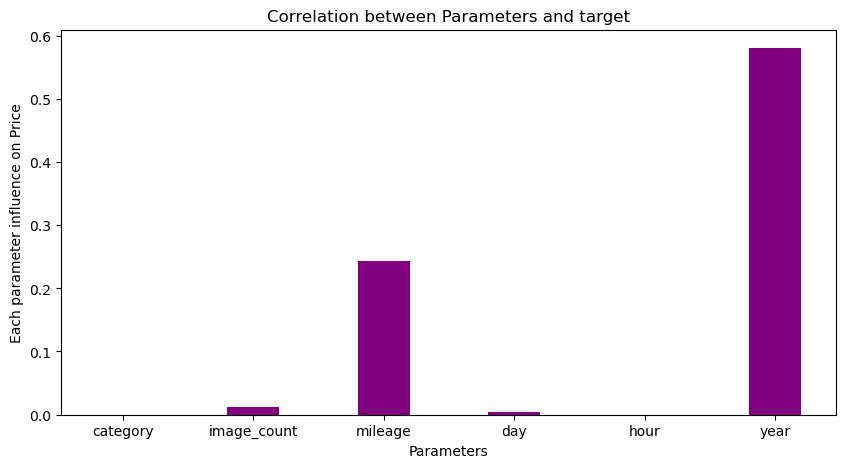

In [15]:
def drawGainPlot(df, inforGain):
    inforList = inforGain.tolist()
    allCol = list(df.columns)
    allCol.remove(target)
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(allCol, inforList, color ='purple', width = 0.4) 

    plt.xlabel("Parameters") 
    plt.ylabel("Each parameter influence on Price") 
    plt.title("Correlation between Parameters and target") 
    plt.show()
    
drawGainPlot(trainInformationGain, inforGain)

In [39]:
trainInformationGain = train.copy()
del trainInformationGain[title]
del trainInformationGain[description]

def returnInformationGain(df):
    dfCopy = df.copy()
    targetList = dfCopy[target].tolist()
    del dfCopy[target]
    result = mutual_info_classif(dfCopy, targetList)
    return result

inforGain = returnInformationGain(trainInformationGain)
inforGain

array([0.        , 0.01246877, 0.24735895, 0.00829704, 0.00404017,
       0.58050213, 0.01445318, 0.00273853, 0.00553681, 0.0221449 ,
       0.01480828, 0.03662328, 0.00535244, 0.01214438, 0.01051087,
       0.01272539, 0.06443329, 0.03852437, 0.00950105, 0.01059977,
       0.0444593 , 0.00392444, 0.01614204, 0.17513607, 0.03365861,
       0.03094129, 0.06722972, 0.02371806, 0.04345529, 0.02880986,
       0.06233661, 0.01100473])

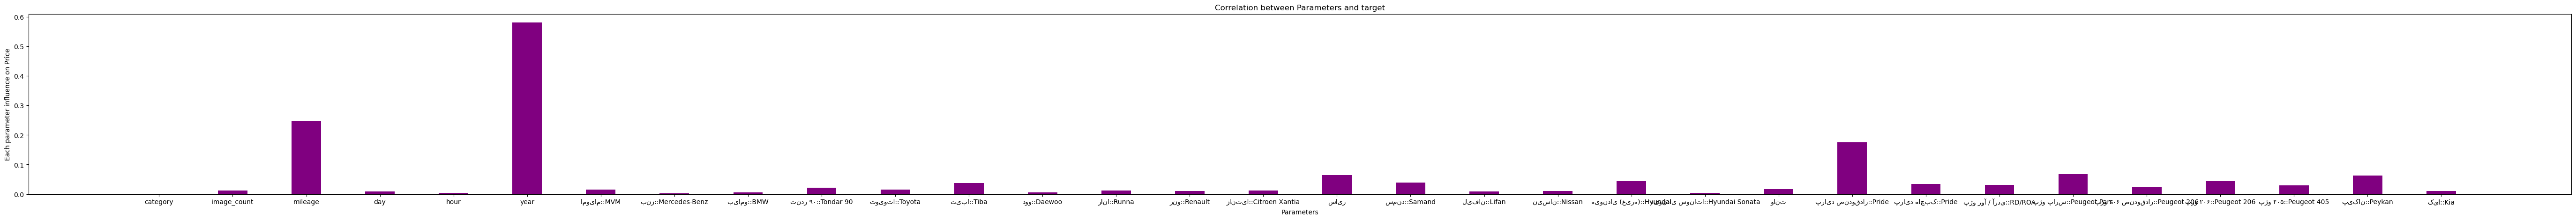

In [42]:
def drawGainPlot(df, inforGain):
    inforList = inforGain.tolist()
    allCol = list(df.columns)
    allCol.remove(target)
    fig = plt.figure(figsize = (70, 5)) 
    plt.bar(allCol, inforList, color ='purple', width = 0.4) 

    plt.xlabel("Parameters") 
    plt.ylabel("Each parameter influence on Price") 
    plt.title("Correlation between Parameters and target") 
    plt.show()
    
drawGainPlot(trainInformationGain, inforGain)

In [16]:
def splitData(train, testSize, randomState, attributesNames, target):
    xTrain, xTest, yTrain, yTest = train_test_split(
        train[attributesNames], train[target], test_size=testSize, random_state=randomState
    )
    return xTrain, xTest, yTrain, yTest
    
    
featureNames = list(train.columns.values)
droppingColumns = [target, title, description, day, hour]

for feature in droppingColumns:
    featureNames.remove(feature)

xTrain, xTest, yTrain, yTest = splitData(train, 0.2, 100, featureNames, target)

In [15]:
def PlotHyperparameter(modelName, rmseList, start, end, hyper):
    values = list(range(start, end))
    fig = plt.figure(figsize = (10, 3))
    plt.plot(values, rmseList, color ='green', marker='o')
    hyper = str(hyper)
    plt.xlabel(hyper) 
    plt.ylabel("RMSE") 
    modelName = str(modelName)
    plt.title(modelName) 
    plt.show()

In [16]:
def GridSearch(estimator, params_model):
    grid_model = GridSearchCV(estimator = estimator , param_grid = params_model, scoring = mse_for_grid)
    grid_result = grid_model.fit(xTrain, yTrain)
    best_params = grid_result.best_params_
    return best_params

# KNN

In [98]:
KNNmodel = KNeighborsRegressor()
KNNhyperparams = {
    'n_neighbors' : list(range(30, 41))
}
bestKNNparams = GridSearch(KNNmodel, KNNhyperparams)
bestKNNparams

{'n_neighbors': 32}

In [99]:
def KNN(n_neighbors):
    estimator = KNeighborsRegressor(n_neighbors= n_neighbors)
    estimator.fit(xTrain, yTrain)
    yPred = estimator.predict(xTest)
    mse = MSE(yTest, yPred)
    rmse = RMSE(yPred, yTest)
    return rmse, mse

rmseKNNList = []
mseKNNList = []
for n_neighbors in range(30 , 41):
    rmse, mse = KNN(n_neighbors)
    mseKNNList.append(mse)
    rmseKNNList.append(rmse)

print('RMSE for KNN : ', min(rmseKNNList))
print('MSE for KNN : ', min(mseKNNList))

RMSE for KNN :  11867376.608293423
MSE for KNN :  140834627563069.56


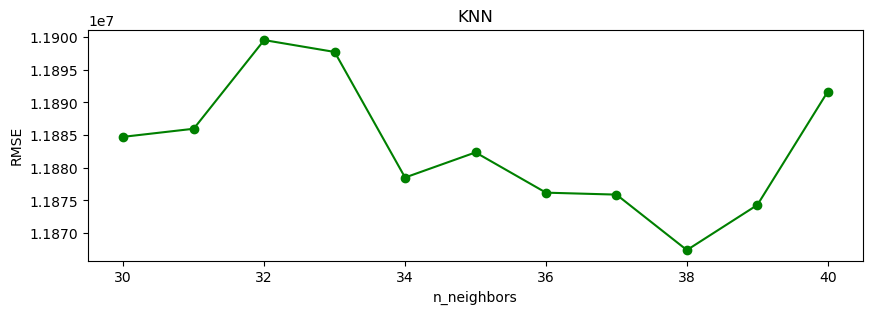

In [194]:
PlotHyperparameter('KNN', rmseKNNList, 30, 41, 'n_neighbors')

# DecisionTree

In [21]:
DTmodel = DecisionTreeRegressor()

# DTmodel.get_params().keys()

DThyperparams = {
    'max_depth' : list(range(13, 16)),
    'min_samples_split' : list(range(83, 86))
}
bestDTparams = GridSearch(DTmodel, DThyperparams)
bestDTparams

{'max_depth': 15, 'min_samples_split': 84}

In [183]:
def DT(max_depth = 5, min_samples_split = 2):
    estimator = DecisionTreeRegressor()
    estimator.fit(xTrain, yTrain)
    yPred = estimator.predict(xTest)
    mse = MSE(yTest, yPred)
    rmse = RMSE(yPred, yTest)
    return rmse, mse

rmseDTList_max_depth = []
mseDTList_max_depth = []
for max_depth in range(5, 20):
    rmse, mse = DT(max_depth)
    mseDTList_max_depth.append(mse)
    rmseDTList_max_depth.append(rmse)

rmseDTList_min_samples_split = []
mseDTList_min_samples_split = []
for min_samples_split in range(80, 90):
    rmse, mse = DT(min_samples_split)
    mseDTList_min_samples_split.append(mse)
    rmseDTList_min_samples_split.append(rmse)    

    
best_max_depth = rmseDTList_max_depth.index(min(rmseDTList_max_depth)) + 80
best_min_split =rmseDTList_min_samples_split.index(min(rmseDTList_min_samples_split))  + 5

bestRMSE, bestMSE = DT(max_depth = best_max_depth, min_samples_split = best_min_split)

print('RMSE for DT : ', bestRMSE)
print('MSE for DT : ', bestMSE)

RMSE for DT :  15262659.20468844
MSE for DT :  232948765998468.16


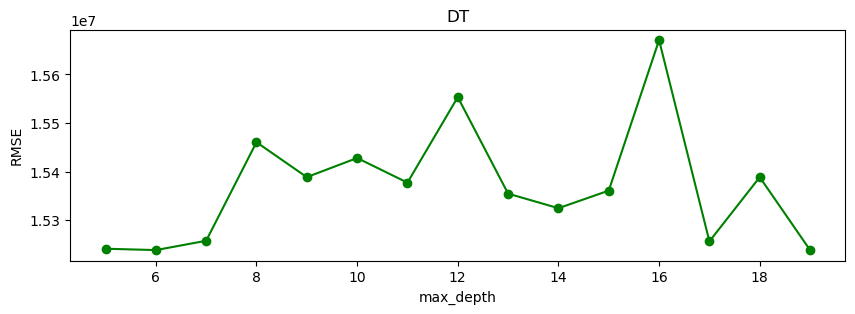

In [195]:
PlotHyperparameter('DT', rmseDTList_max_depth, 5,  20, 'max_depth')

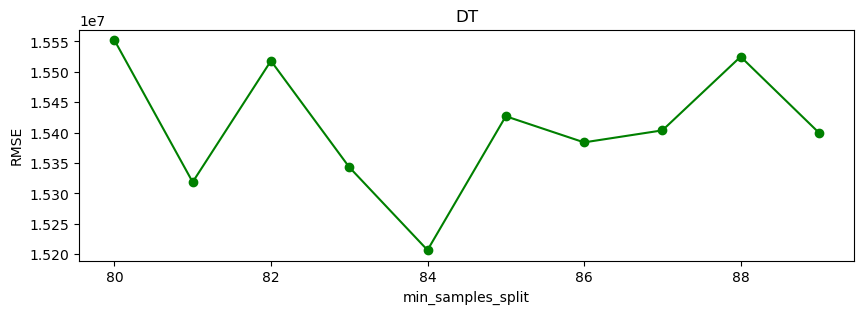

In [197]:
PlotHyperparameter('DT', rmseDTList_min_samples_split, 80,  90, 'min_samples_split')

# Linear Regression

In [18]:
estimator = LinearRegression()
estimator.fit(xTrain, yTrain)
yPred = estimator.predict(xTest)
mse = MSE(yTest, yPred)
rmse = RMSE(yPred, yTest)

print('RMSE for KNN : ', rmse)
print('MSE for KNN : ', mse)

RMSE for KNN :  15484710.188466514
MSE for KNN :  239776249620799.8


# Random Forest

In [20]:
RFRmodel = RandomForestRegressor()
RFRhyperparams = {
    'n_estimators' : list(range(94, 98)),
    'max_depth' : list(range(13, 16))
}
bestRFRparams = GridSearch(RFRmodel, RFRhyperparams)
bestRFRparams

{'max_depth': 15, 'n_estimators': 97}

In [25]:
def RFR(n_estimators = 97, max_depth = 15):
    estimator = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth)
    estimator.fit(xTrain, yTrain)
    yPred = estimator.predict(xTest)
    mse = MSE(yTest, yPred)
    rmse = RMSE(yPred, yTest)
    return rmse, mse

rmseRFRList_max_depth = []
mseRFRList_max_depth = []
for max_depth in range(13, 20):
    rmse, mse = RFR(max_depth)
    mseRFRList_max_depth.append(mse)
    rmseRFRList_max_depth.append(rmse)

rmseRFRList_n_estimators = []
mseRFRList_n_estimators = []
for n_estimators in range(95, 98):
    rmse, mse = RFR(n_estimators)
    mseRFRList_n_estimators.append(mse)
    rmseRFRList_n_estimators.append(rmse)  

    
best_max_depth = rmseRFRList_max_depth.index(min(rmseRFRList_max_depth)) + 13
best_n_estimators = rmseRFRList_n_estimators.index(min(rmseRFRList_n_estimators))  + 95

bestRMSE, bestMSE = RFR(max_depth = best_max_depth, n_estimators = best_n_estimators)

print('RMSE for RFR : ', bestRMSE)
print('MSE for RFR : ', bestMSE)

RMSE for RFR :  12432035.248538334
MSE for RFR :  154555500420899.2


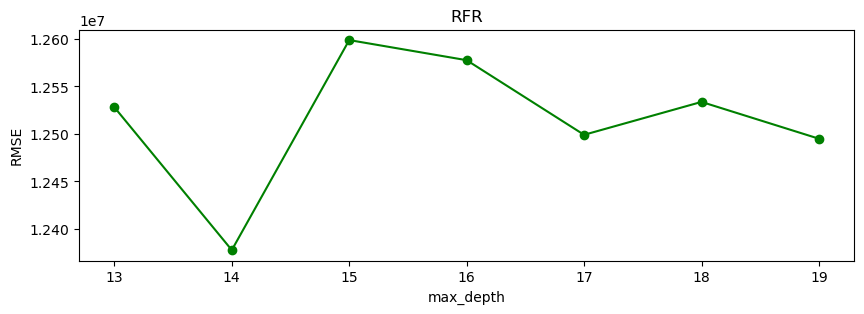

In [26]:
PlotHyperparameter('RFR', rmseRFRList_max_depth, 13, 20, 'max_depth')

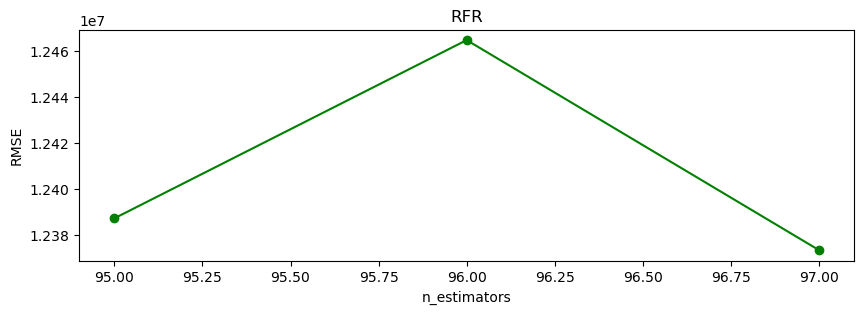

In [27]:
PlotHyperparameter('RFR', rmseRFRList_n_estimators, 95,  98, 'n_estimators')